# P5:从安然公司邮件中发现欺诈证据

## 概述

项目目标是通过公开的安然财务和邮件数据集，找出有欺诈嫌疑的安然雇员。使用监督机器学习可以让计算机根据已有的数据训练处可以推测新数据是否有欺诈嫌疑的算法，并可以通过反复优化算法以获得更高的准确率。


数据中包含异常值，key是"TOTAL"，猜测是电子表格中的汇总数据误填进来了。处理方法是删掉。

In [1]:
% pylab inline
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit


with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

Populating the interactive namespace from numpy and matplotlib


In [2]:
print "数据点总数: ",len(data_dict)

数据点总数:  146


In [3]:
data_dict.values()[0]

{'bonus': 600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'mark.metts@enron.com',
 'exercised_stock_options': 'NaN',
 'expenses': 94299,
 'from_messages': 29,
 'from_poi_to_this_person': 38,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 1740,
 'poi': False,
 'restricted_stock': 585062,
 'restricted_stock_deferred': 'NaN',
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_messages': 807,
 'total_payments': 1061827,
 'total_stock_value': 585062}

In [4]:
print len(data_dict.values()[0])

21


In [5]:
# 改变数据把相同的特征放到同一个list中
trans_data = {k:[] for k in data_dict.values()[0].keys()}
for _, raw in data_dict.items():
    for k, v in raw.items():
        trans_data[k].append(v)

其中poi是标签，不做为分析特征，所以总共有20个特征。分别是：

salary, to_messages, deferral_payments, total_payments, exercised_stock_options, bonus, restricted_stock, shared_receipt_with_poi, restricted_stock_deferred, total_stock_value, expenses, loan_advances, from_messages, other, from_this_person_to_poi, director_fees, deferred_income, long_term_incentive, from_poi_to_this_person

In [6]:
print " 特征包含缺失值的数量:"
for k, v in sorted(trans_data.items(), key=lambda x:x[1].count("NaN"), reverse=True):
    print("{:5}: {}".format(v.count("NaN"), k))

 特征包含缺失值的数量:
  142: loan_advances
  129: director_fees
  128: restricted_stock_deferred
  107: deferral_payments
   97: deferred_income
   80: long_term_incentive
   64: bonus
   60: to_messages
   60: shared_receipt_with_poi
   60: from_messages
   60: from_poi_to_this_person
   60: from_this_person_to_poi
   53: other
   51: salary
   51: expenses
   44: exercised_stock_options
   36: restricted_stock
   35: email_address
   21: total_payments
   20: total_stock_value
    0: poi


loan_advances，director_fees，restricted_stock_deferred，deferral_payments，deferred_income，long_term_incentive 等都包含了大量的缺失值，在featureFormat 方法中做了补零处理(使用sklearn.preprocessing.Imputer可以对缺失值进行处理)。

In [7]:
for k, v in sorted(data_dict.items(), key=lambda v:v[1].values().count("NaN"), reverse=True)[:10]:
    print(k, v.values().count("NaN"))


('LOCKHART EUGENE E', 20)
('WHALEY DAVID A', 18)
('WROBEL BRUCE', 18)
('THE TRAVEL AGENCY IN THE PARK', 18)
('GRAMM WENDY L', 18)
('WODRASKA JOHN', 17)
('CLINE KENNETH W', 17)
('WAKEHAM JOHN', 17)
('SCRIMSHAW MATTHEW', 17)
('GILLIS JOHN', 17)


In [8]:
data_dict["LOCKHART EUGENE E"]

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 'NaN',
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 'NaN',
 'total_stock_value': 'NaN'}

“LOCKHART EUGENE E”的20个特征皆为NaN，“THE TRAVEL AGENCY IN THE PARK”显然不是一个人名，所以这两个都是异常值

In [9]:
data_dict.pop("LOCKHART EUGENE E")
data_dict.pop("THE TRAVEL AGENCY IN THE PARK")

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

In [10]:
# 对data_dict中的缺失值进行补零
for v in data_dict.values():
    for k in v:
        # email_address是电子邮件地址是字符串，poi是标签且没有缺失值，这两个值忽略
        if k in {"email_address", "poi"}:
            continue
        if v[k] == "NaN":
            v[k] = 0

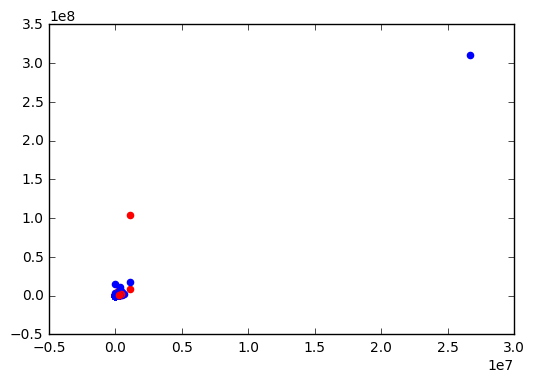

In [11]:
for v in data_dict.values():
    x, y = v["salary"], v["total_payments"]
    color = "r" if v["poi"] else 'b'
    if x == "NaN" or y == "NaN":
        continue
    plt.scatter(float(x), float(y), color=color)

In [12]:
max(data_dict, key=lambda k:data_dict[k]["salary"])

'TOTAL'

In [13]:
# 从名字可以看出这个值有问题,移除
data_dict.pop("TOTAL")

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 0,
 'from_poi_to_this_person': 0,
 'from_this_person_to_poi': 0,
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 0,
 'to_messages': 0,
 'total_payments': 309886585,
 'total_stock_value': 434509511}

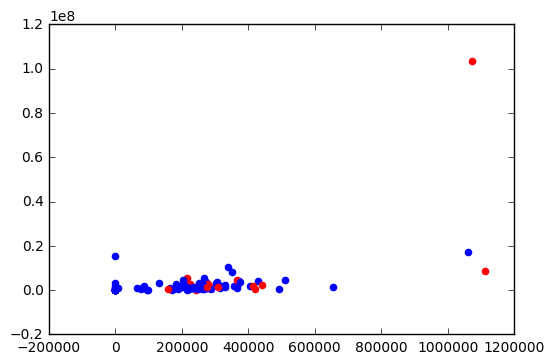

In [14]:
for v in data_dict.values():
    x, y = v["salary"], v["total_payments"]
    color = "r" if v["poi"] else 'b'
    if x == "NaN" or y == "NaN":
        continue
    plt.scatter(float(x), float(y), color=color)

In [15]:
# boss级人物，薪水高正常
sorted(data_dict, key=lambda k:data_dict[k], reverse=True)[:3]

['LAVORATO JOHN J', 'LAY KENNETH L', 'SKILLING JEFFREY K']

In [16]:
# 重置trans_data 改变数据把相同的特征放到同一个list中
trans_data = {k:[] for k in data_dict.values()[0].keys()}
for _, raw in data_dict.items():
    for k, v in raw.items():
        trans_data[k].append(v)
print "有效数据点总数: ",len(data_dict)
print "POI个数：", trans_data["poi"].count(1)
print "非POI个数：", trans_data["poi"].count(0)

有效数据点总数:  143
POI个数： 18
非POI个数： 125


数据中总共找到3个异常值，处理方法是删掉，删掉异常值后的数据点数是143，3个异常值分别是：
- “LOCKHART EUGENE E”   20个特征皆为NaN
- ”THE TRAVEL AGENCY IN THE PARK“      显然不是个人名
- “TOTAL”               猜测是电子表格中的汇总数据误填进来了。

## 特征

考虑到可能因为工作性质的原因会影响员工发邮件的频率，准备**创建两个个新特征**来消除这方面的影响。如下

- 新特征from_poi_to_this_person_rate表示员工收到的邮件中，poi所占的比例。计算方式是 收到poi发送邮件的总数/收到邮件的总数。

- 新特征from_this_person_to_poi_rate表示员工收到的邮件中，poi所占的比例。计算方式是 发送给poi邮件的总数/发出邮件的总数。

选择特征时使用了SelectKBest选择器，按照得到的分值排序，从高到低依次增加特征进行训练，然后整体对比(具体测试结果下文有列出)，最终使用的特征是exercised_stock_options、total_stock_value、bonus。测试时测试了新特征from_this_person_to_poi_rate，可惜结果不是很理想(下文有具体数据)。

以下是大致分析过程

In [17]:
data_dict.values()[0]

{'bonus': 600000,
 'deferral_payments': 0,
 'deferred_income': 0,
 'director_fees': 0,
 'email_address': 'mark.metts@enron.com',
 'exercised_stock_options': 0,
 'expenses': 94299,
 'from_messages': 29,
 'from_poi_to_this_person': 38,
 'from_this_person_to_poi': 1,
 'loan_advances': 0,
 'long_term_incentive': 0,
 'other': 1740,
 'poi': False,
 'restricted_stock': 585062,
 'restricted_stock_deferred': 0,
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_messages': 807,
 'total_payments': 1061827,
 'total_stock_value': 585062}

In [18]:
# 创建新特征from_poi_to_this_person_rate 和 from_this_person_to_poi_rate
for name, attrs in data_dict.items():
    if attrs["from_messages"] != "NaN" \
        and attrs["from_messages"] \
        and attrs["from_this_person_to_poi"] != "NaN":
        attrs["from_this_person_to_poi_rate"] = 1.0 * attrs["from_this_person_to_poi"] / attrs["from_messages"]
    else:
        attrs["from_this_person_to_poi_rate"] = "NaN"
    if attrs["to_messages"] != "NaN" \
        and attrs["to_messages"] \
        and attrs["from_poi_to_this_person"] != "NaN":
        attrs["from_poi_to_this_person_rate"] = 1.0 * attrs["from_poi_to_this_person"] / attrs["to_messages"]
    else:
        attrs["from_poi_to_this_person_rate"] = "NaN"

In [19]:

# 获取特征数据
features_list = data_dict.values()[0].keys()
# email_address 是字符串 在这里排除掉
features_list.remove("email_address")
# poi 是label 根据featureFormat的参数要求，需要前置
features_list.remove("poi")
features_list.insert(0, "poi")

data = featureFormat(data_dict, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)


In [20]:
# 使用SelectKBest选择器查看每个特征的评分
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif)
selector.fit(features, labels)
for feature_name, score in sorted(zip(features_list[1:], selector.scores_), 
                                  key=lambda x:x[1], 
                                  reverse=True):
    print "{:30s}:    {}".format(feature_name, score)



exercised_stock_options       :    24.8150797332
total_stock_value             :    24.1828986786
bonus                         :    20.7922520472
salary                        :    18.2896840434
from_this_person_to_poi_rate  :    16.409712548
deferred_income               :    11.4584765793
long_term_incentive           :    9.92218601319
restricted_stock              :    9.21281062198
total_payments                :    8.77277773009
shared_receipt_with_poi       :    8.58942073168
loan_advances                 :    7.18405565829
expenses                      :    6.09417331064
from_poi_to_this_person       :    5.24344971337
other                         :    4.187477507
from_poi_to_this_person_rate  :    3.12809174816
from_this_person_to_poi       :    2.38261210823
director_fees                 :    2.12632780201
to_messages                   :    1.64634112944
deferral_payments             :    0.224611274736
from_messages                 :    0.169700947622
restricted_stock_defe

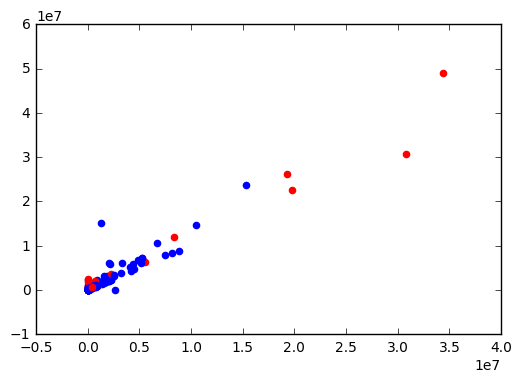

In [21]:
for v in data_dict.values():
    x, y = v["exercised_stock_options"], v["total_stock_value"]
    color = "r" if v["poi"] else 'b'
    if x == "NaN" or y == "NaN":
        continue
    plt.scatter(float(x), float(y), color=color)

In [22]:
from sklearn.cross_validation import StratifiedShuffleSplit


def test_classifier_for_return(clf, dataset, feature_list, folds = 1000):
    """
    测试分类器效果，return指标值
    return accuracy, precision, recall, f1, f2
    """
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        # 预测结果是嫌疑人的数据中正确的比例
        precision = 1.0*true_positives/(true_positives+false_positives)
        # 所有嫌疑人中正确预测到的比例
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        return accuracy, precision, recall, f1, f2
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."


/Users/mengyu/env/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tester import test_classifier


print "|ID|参数|accuracy|precision|recall|f1|f2|"
print "|-:-|-:-|-:-|-:-|-:-|-:-|-:-|-:-|-:-|"

i = 1
features = ["poi"]
for f in ["exercised_stock_options", "total_stock_value", 
          "bonus", "salary", "from_this_person_to_poi_rate", 
          "deferred_income", "long_term_incentive", 
          "restricted_stock"]:
    features.append(f)
    # 特征需要缩放
    clf = Pipeline([
#         ("scaler",MinMaxScaler()), 
        ("clf", DecisionTreeClassifier(random_state=42))
    ])
    result = test_classifier_for_return(clf, data_dict, features)
    if result:
        print "|{}|{}|{:.3f}| {:.3f}|{:.3f}|{:.3f}|{:.3f}|".format(
            i, 
            "{}".format(", ".join(features[1:])), *result)
        i += 1

|ID|参数|accuracy|precision|recall|f1|f2|
|-:-|-:-|-:-|-:-|-:-|-:-|-:-|-:-|-:-|
|1|exercised_stock_options|0.863| 0.274|0.310|0.291|0.302|
|2|exercised_stock_options, total_stock_value|0.769| 0.231|0.214|0.222|0.217|
|3|exercised_stock_options, total_stock_value, bonus|0.803| 0.373|0.408|0.389|0.400|
|4|exercised_stock_options, total_stock_value, bonus, salary|0.786| 0.310|0.322|0.316|0.319|
|5|exercised_stock_options, total_stock_value, bonus, salary, from_this_person_to_poi_rate|0.782| 0.266|0.300|0.282|0.292|
|6|exercised_stock_options, total_stock_value, bonus, salary, from_this_person_to_poi_rate, deferred_income|0.794| 0.272|0.265|0.268|0.266|
|7|exercised_stock_options, total_stock_value, bonus, salary, from_this_person_to_poi_rate, deferred_income, long_term_incentive|0.794| 0.268|0.255|0.261|0.258|
|8|exercised_stock_options, total_stock_value, bonus, salary, from_this_person_to_poi_rate, deferred_income, long_term_incentive, restricted_stock|0.791| 0.249|0.231|0.240|0.234|


按照得到的分值排序，从高到低依次增加特征在不优化参数采用贝叶斯算法算法下进行训练，所得到的结果如下：

|ID|参数|accuracy|precision|recall|f1|f2|
|-:-|-:-|-:-|-:-|-:-|-:-|-:-|-:-|-:-|
|1|exercised_stock_options|0.863| 0.274|0.310|0.291|0.302|
|2|exercised_stock_options, total_stock_value|0.769| 0.231|0.214|0.222|0.217|
|3|exercised_stock_options, total_stock_value, bonus|0.803| 0.373|0.408|0.389|0.400|
|4|exercised_stock_options, total_stock_value, bonus, salary|0.786| 0.310|0.322|0.316|0.319|
|5|exercised_stock_options, total_stock_value, bonus, salary, from_this_person_to_poi_rate|0.782| 0.266|0.300|0.282|0.292|
|6|exercised_stock_options, total_stock_value, bonus, salary, from_this_person_to_poi_rate, deferred_income|0.794| 0.272|0.265|0.268|0.266|
|7|exercised_stock_options, total_stock_value, bonus, salary, from_this_person_to_poi_rate, deferred_income, long_term_incentive|0.794| 0.268|0.255|0.261|0.258|
|8|exercised_stock_options, total_stock_value, bonus, salary, from_this_person_to_poi_rate, deferred_income, long_term_incentive, restricted_stock|0.791| 0.249|0.231|0.240|0.234|


```
        注：accuracy 预测结果正确值/预测总数；precision 预测结果是嫌疑人的数据中正确的比例；recall所有嫌疑人中正确预测到的比例
```

指标accuracy表示预测是嫌疑人和不是嫌疑人整体的正确率，本次预测的目的是找出嫌疑人，所以使用precision和recall这两个指标更合适，precision 预测结果是嫌疑人的数据中正确的比例；recall所有嫌疑人中正确预测到的比例。

上表可以看出第 exercised_stock_options, total_stock_value, bonus的时候precision和recall整体是最佳的，故而选择这3个特征继续进行优化。
表中在第5行增加了**新特征**from_this_person_to_poi_rate，相比于第4行而言所有指标都下降，说明**使用新特征会使算法的性能降低**(使用决策树算法的时候是这样)，所以最终使用的特征为

- exercised_stock_options
- total_stock_value
- bonus

在使用不同算法简单评估性能的时候，贝叶斯和决策树算法不需要缩放，KKN算法需要进行缩放，使用MinMaxScaler。

## 算法

#### 调整参数的意义
适当的参数调整可以提高算法的训练时间或预测时间，提高算法的accuracy，precision，recall等性能指标，还可以防止算法的过拟合。

#### KNN算法

KNN分类的原理是在分类时对于新的实例，会根据k个最邻近的训练实例的类别，通过多数表决等方式进行预测。

- n_neighbors参数指定的是算法中的k值。该值过小会对噪声敏感，容易发生过拟合；该值过大时会忽略训练实例中很多有用的信息。
- weights参数表示投票权重类型。uniform表示所有邻居节点的投票权重相等；distance表示邻居节点的投票权重和距离呈反比，即越近的节点权重越大。

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tester import test_classifier


print "|ID|参数|accuracy|precision|recall|f1|f2|"
print "|-:-|-:-|-:-|-:-|-:-|-:-|-:-|-:-|-:-|"
features = ["poi", "exercised_stock_options", "total_stock_value", "bonus"]

i = 1
for weights in ["uniform", "distance"]:
    for n_neighbors in range(1, 7):
        # 特征需要缩放
        clf = Pipeline([
            ("scaler",MinMaxScaler()), 
            ("clf", KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights))
        ])
        result = test_classifier_for_return(clf, data_dict, features)
        if result:
            print "|{}|{}|{:.3f}| {:.3f}|{:.3f}|{:.3f}|{:.3f}|".format(i, "n_neighbors:{},weights:{}".format(n_neighbors,weights), *result)
            i += 1

|ID|参数|accuracy|precision|recall|f1|f2|
|-:-|-:-|-:-|-:-|-:-|-:-|-:-|-:-|-:-|
|1|n_neighbors:1,weights:uniform|0.816| 0.397|0.380|0.388|0.383|
|2|n_neighbors:2,weights:uniform|0.869| 0.765|0.213|0.334|0.249|
|3|n_neighbors:3,weights:uniform|0.860| 0.583|0.306|0.401|0.338|
|4|n_neighbors:4,weights:uniform|0.869| 0.798|0.196|0.314|0.230|
|5|n_neighbors:5,weights:uniform|0.878| 0.797|0.280|0.414|0.322|
|6|n_neighbors:6,weights:uniform|0.847| 0.543|0.044|0.082|0.055|
|7|n_neighbors:1,weights:distance|0.816| 0.397|0.380|0.388|0.383|
|8|n_neighbors:2,weights:distance|0.816| 0.397|0.380|0.388|0.383|
|9|n_neighbors:3,weights:distance|0.852| 0.532|0.308|0.391|0.337|
|10|n_neighbors:4,weights:distance|0.862| 0.576|0.381|0.458|0.408|
|11|n_neighbors:5,weights:distance|0.876| 0.739|0.298|0.425|0.338|
|12|n_neighbors:6,weights:distance|0.874| 0.713|0.304|0.426|0.343|


整理结果如下：

|ID|参数|accuracy|precision|recall|f1|f2|
|-:-|-:-|-:-|-:-|-:-|-:-|-:-|-:-|-:-|
|1|n_neighbors:1,weights:uniform|0.816| 0.397|0.380|0.388|0.383|
|2|n_neighbors:2,weights:uniform|0.869| 0.765|0.213|0.334|0.249|
|3|n_neighbors:3,weights:uniform|0.860| 0.583|0.306|0.401|0.338|
|4|n_neighbors:4,weights:uniform|0.869| 0.798|0.196|0.314|0.230|
|5|n_neighbors:5,weights:uniform|0.878| 0.797|0.280|0.414|0.322|
|6|n_neighbors:6,weights:uniform|0.847| 0.543|0.044|0.082|0.055|
|7|n_neighbors:1,weights:distance|0.816| 0.397|0.380|0.388|0.383|
|8|n_neighbors:2,weights:distance|0.816| 0.397|0.380|0.388|0.383|
|9|n_neighbors:3,weights:distance|0.852| 0.532|0.308|0.391|0.337|
|10|**n_neighbors:4,weights:distance**|0.862| 0.576|0.381|0.458|0.408|
|11|n_neighbors:5,weights:distance|0.876| 0.739|0.298|0.425|0.338|
|12|n_neighbors:6,weights:distance|0.874| 0.713|0.304|0.426|0.343|



上面表格中可以看出当参数为n_neighbors:4,weights:distance时，precision和recall的值整体都比较高，分别为0.576和0.381。

#### 贝叶斯算法

使用 naive_bayes.GaussianNB类，没有需要调整的参数

In [25]:
from sklearn.naive_bayes import GaussianNB


# 特征需要缩放
features = ["poi", "exercised_stock_options", "total_stock_value", "bonus"]
clf = GaussianNB()
result = test_classifier_for_return(clf, data_dict, features)
print "|accuracy|precision|recall|f1|f2|"
print "|-:-|-:-|-:-|-:-|-:-|-:-|-:-|"
print "| {:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}|".format(*result)

|accuracy|precision|recall|f1|f2|
|-:-|-:-|-:-|-:-|-:-|-:-|-:-|
| 0.843|0.486|0.351|0.408|0.372|


|accuracy|precision|recall|f1|f2|
|-:-|-:-|-:-|-:-|-:-|-:-|-:-|
| 0.843|0.486|0.351|0.408|0.372|

#### 决策树分类算法

调整的参数意义:

- criterion 可以取值'gini'(Gini系数)或'entropy(熵)'，表示切分质量的评价准则。
- max_features 表示每次切分考虑特征的数量

In [26]:
print "|id|参数|accuracy|precision|recall|f1|f2|"
print "|-:-|-:-|-:-|-:-|-:-|-:-|-:-|-:-|-:-|"
features = ["poi", "exercised_stock_options", "total_stock_value", "bonus"]
i = 1
for criterion in ["gini", "entropy"]:
    for max_features in [1, 2, 3]:
        clf = DecisionTreeClassifier(
            criterion=criterion, 
            max_features=max_features,
            random_state=42
        )
        result = test_classifier_for_return(clf, data_dict, features)
        if result:
            print "|{}|{}|{:.3f}| {:.3f}|{:.3f}|{:.3f}|{:.3f}|".format(
                i, 
                "criterion:{}, max_features:{}".format(
                    criterion, max_features
                ), 
                *result)
            i += 1

|id|参数|accuracy|precision|recall|f1|f2|
|-:-|-:-|-:-|-:-|-:-|-:-|-:-|-:-|-:-|
|1|criterion:gini, max_features:1|0.821| 0.425|0.469|0.446|0.460|
|2|criterion:gini, max_features:2|0.811| 0.388|0.401|0.395|0.398|
|3|criterion:gini, max_features:3|0.803| 0.373|0.408|0.389|0.400|
|4|criterion:entropy, max_features:1|0.827| 0.442|0.480|0.461|0.472|
|5|criterion:entropy, max_features:2|0.823| 0.424|0.417|0.421|0.419|
|6|criterion:entropy, max_features:3|0.799| 0.358|0.392|0.374|0.385|


得到下表：

|id|参数|accuracy|precision|recall|f1|f2|
|-:-|-:-|-:-|-:-|-:-|-:-|-:-|-:-|-:-|
|1|criterion:gini, max_features:1|0.821| 0.425|0.469|0.446|0.460|
|2|criterion:gini, max_features:2|0.811| 0.388|0.401|0.395|0.398|
|3|criterion:gini, max_features:3|0.803| 0.373|0.408|0.389|0.400|
|4|criterion:entropy, max_features:1|0.827| 0.442|0.480|0.461|0.472|
|5|criterion:entropy, max_features:2|0.823| 0.424|0.417|0.421|0.419|
|6|criterion:entropy, max_features:3|0.799| 0.358|0.392|0.374|0.385|

可以看出第4行的precision和recall整体最高，达到了0.442和0.480, 最终选择调整的参数为criterion:entropy, max_features:1。

#### 小结

以上每种算法得到的最优结果分别是

|算法|accuracy|precision|recall|
|-:-|-:-|-:-|-:-|-:-|-:-|
|KNN|0.862| 0.576|0.381|
|贝叶斯| 0.843|0.486|0.351|
|决策树分类|0.827| 0.442|0.480|


分别尝试了KNN、高斯贝叶斯以及决策树分类等算法，对KNN和决策树算法的参数进行了调优。因为最终评测的指标主要是precision和recall，所以没有使用GridSearchCV，而是自己写代码进行了各种参数的比较。根据验证结果最终选定了决策树分类算法。

调整决策树算法的时候遇到一个问题，在不设置random_state的时候结果有一定的随机性，这是因为实现的决策树有一定的随机性，所以在评估的时候设置随机数种子，这样可以正常做对比。

## 验证

**验证**是指将独立训练集按照一定的方式拆分成训练集和测试集，使用分类或回归算法用训练集建立模型，然后再用测试集对模型进行验证。验证的**重要性**在于，通过测试数据可以评估分类器或者回归在独立数据集上的性能。 如果没有正确执行验证，可能导致算法的过拟合。

评估算法中使用了**precision**和**recall**两个性能**指标**，precision表示预测结果为poi的员工中真实poi的比例，recall表示所有poi员工中被预测出来的比例。本次目标是找出有欺诈嫌疑的安然雇员，所以需要考虑recall和precision这两个指标，其中recall稍重要一些。

**验证方式**使用了StratifiedShuffleSplit对数据集进行训练和测试集的拆分。 由于整体数据集的不平衡性(非POI为125，POI为18个)，且数据量较少,常规的拆分方式有一定概率会把poi全部分到训练集和测试集中。而使用StratifiedShuffleSplit生成的n组train/test数据集，可以保证每组都与与整体数据中的POI分布百分比一致。


最终的**结果**分析如下：
- accuracy的平均值为0.827，表示识别一个人是否是嫌疑人的准确率是82.7%；
- precision的平均值是0.442，表示如果该算法识别一个人是嫌疑人，正确的概率是44.2%；
- recall的平均值是0.480，表示该算法能找出数据集中48%的嫌疑人
